In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from sklearn.model_selection import KFold, LeaveOneOut

from bamf.bamf import *

import time

np.random.seed(12345)

# Define number of K-Folds 

In [2]:
# Comment out if using Leave One Out
K = 3

# Define variable names

In [3]:
# number of species
NS = 7

species = ["s"+str(i+1) for i in range(NS)]
species

['s1', 's2', 's3', 's4', 's5', 's6', 's7']

# Import sequenced data

In [4]:
full_data = pd.read_csv("gLV_data/Simulated_gLV_data_full.csv")
full_data

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7
0,exp_1,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,48.0,0.298559,0.159095,0.081960,0.215479,0.016468,0.168590,0.000057
2,exp_2,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000
3,exp_2,48.0,0.286262,0.165522,0.065139,0.155305,0.025074,0.212555,0.000000
4,exp_3,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000,0.100000
...,...,...,...,...,...,...,...,...,...
249,exp_125,48.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.337060,0.118508
250,mono_exp_126,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
251,mono_exp_126,48.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.548540,0.000000
252,mono_exp_127,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000


## sum-of-OD data

In [5]:
sum_data = pd.read_csv("gLV_data/Simulated_gLV_data_sum.csv")
sum_data

,Treatments,Time,OD,s1,s2,s3,s4,s5,s6,s7
0,exp_1,0.0,0.700000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,1.0,0.603124,0.139175,0.115084,0.112920,0.111055,0.104585,0.116198,0.086675
2,exp_1,2.0,0.863875,0.180531,0.128074,0.122424,0.121131,0.104713,0.130274,0.073863
3,exp_1,3.0,1.025633,0.218637,0.138798,0.128066,0.130070,0.101389,0.141819,0.062099
4,exp_1,4.0,0.868276,0.249608,0.147425,0.130253,0.137868,0.096018,0.150858,0.051734
...,...,...,...,...,...,...,...,...,...,...
6218,mono_exp_127,44.0,0.149115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144137
6219,mono_exp_127,45.0,0.157048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144124
6220,mono_exp_127,46.0,0.126141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144121
6221,mono_exp_127,47.0,0.133857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144130


# Define function to make predictions on test data

In [6]:
# Define function to make predictions on test data

def test_model(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # test full community
        output, stdv, COV = model.predict(x_test, tspan)

        # save predictions after initial value 
        for i, (true, pred, std) in enumerate(zip(output_true[1:], output[1:], stdv[1:])):
            y_true += list(true)
            y_pred += list(pred)
            y_std  += list(std)
            test_times += [tspan[i+1]]*numspecies
            all_species_names += list(species)
            test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+5)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval)   

            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i in range(numspecies):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label=f"Predicted {species[i]}", color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return test_treatments, test_times, all_species_names, y_true, y_pred, y_std

# Define function to make predictions on test data

def test_mf(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1]+5)
        steps = len(t_eval)
        output, stdv, COV = model.predict(x_test, t_eval)   
        
        # apply lossy function
        output_true = np.sum(output_true, 1)
        output = np.sum(output, 1)
        stdv = np.sum(stdv, 1)

        # plot the results
        plt.figure(figsize=(9, 6))
        plt.scatter(tspan, output_true, color='C0')
        plt.plot(t_eval, output, label=f"Predicted sum", color='C0')
        plt.fill_between(t_eval, output-stdv, output+stdv, color='C0', alpha=0.2)

        plt.xlabel("time", fontsize=16)
        plt.ylabel("Abundance", fontsize=16)
        plt.legend(loc='upper left')
        plt.title(f"Treatment {treatment} predictions")
        #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
        #plt.close()
        plt.show()

# Initialize model parameters

In [7]:
# system dimensions
ns = len(species)
nu = 0

# map to hidden dimension
stdv = 1./np.sqrt(ns*ns)
A = np.random.uniform(0, -stdv, [ns, ns])
a = np.random.uniform(0, stdv, ns)

# concatenate parameters 
params = np.concatenate((A.flatten(), a))
prior  = np.zeros_like(params)

n_params = len(params)
n_params

56

# Define model

In [8]:
# using NODE model 
def system(t, s, params, ctrl_params): 
    
    # map to hidden dimension
    A = jnp.reshape(params[:ns**2], [ns,ns])
    a = params[ns**2:]

    # rate of change of species 
    dsdt = s * (A@s + a)

    return dsdt

# Define compression functions

In [9]:
# define compression functions 
compressor0 = lambda x: jnp.expand_dims(jnp.sum(x), 0)     # sum over outputs 
compressor1 = lambda x: x

compressors = [compressor0, compressor1]

In [10]:
# pull treatment names 
all_sum_treatments = sum_data.Treatments.values
all_treatments = full_data.Treatments.values
unique_treatments = np.unique(all_treatments)

# set up kfold iterator
kf = KFold(n_splits = K) 

# set up list of measured and predicted values
kfold_species_names = []
kfold_y_true = []
kfold_y_pred = []
kfold_y_stdv = []

# iterate over folds 
for train_index, test_index in kf.split(unique_treatments):
    # train_index, test_index = next(iter(kf.split(unique_treatments)))

    # get index of train and test data
    train_inds = np.in1d(all_treatments, unique_treatments[train_index])
    test_inds  = np.in1d(all_treatments, unique_treatments[test_index])

    # pull out train and test data 
    df_train = full_data.iloc[train_inds].copy()
    df_test  = full_data.iloc[test_inds].copy()

    # instantiate gLV fit 
    model = ODE(system = system, 
                dataframes=[sum_data, df_train],
                compressors = compressors,
                params = params, 
                prior = prior,
                sys_vars = species,
                measured_vars = [['OD'], species],
                verbose=True)
    
    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, beta_tol=1e-3)
    print("Elapsed time {:.2f}s".format(time.time()-t0))

    # predict held-out data
    test_treatments, test_times, all_species_names, y_true, y_pred, y_std = test_model(model, df_test, species, plot=False)
    kfold_species_names += all_species_names
    kfold_y_true += y_true
    kfold_y_pred += y_pred
    kfold_y_stdv += y_std

Updating precision...
Total samples: 913, Updated regularization: 1.54e-01
Total weighted fitting error: 382.591
Total weighted fitting error: 329.417
Total weighted fitting error: 236.152
Total weighted fitting error: 184.233
Total weighted fitting error: 180.953
     fun: 180.95276600687183
     jac: array([ 6.66829071e+01,  1.42503309e+00, -4.98926818e-01,  3.44645977e-02,
        3.47286873e+01,  1.95499840e+01, -1.15890703e+01, -1.49843514e-01,
        5.48188782e+01, -2.30453300e+01, -1.09802179e+01,  1.48440514e+01,
        2.15118980e+01,  2.08163500e-01,  2.75086937e+01,  1.77908440e+01,
        5.79035149e+01, -3.01988163e+01, -4.50091705e+01, -6.16362095e-01,
       -3.91792870e+00, -5.78710890e+00,  2.34485865e+00, -1.22012768e+01,
        6.42491074e+01, -3.06729069e+01, -6.13631516e+01, -4.93855476e+00,
        5.05371933e+01,  3.13479519e+01,  2.56670723e+01,  5.75910149e+01,
        2.53719894e+02,  1.13880226e+02,  6.19040728e-01,  3.42054329e+01,
        1.60734653e+0

Evidence 1321.029
Updating precision...
Total samples: 913, Updated regularization: 2.65e-02
Total weighted fitting error: 543.407
Total weighted fitting error: 540.604
Total weighted fitting error: 536.779
Total weighted fitting error: 530.075
Total weighted fitting error: 520.905
Total weighted fitting error: 518.413
Total weighted fitting error: 518.106
Total weighted fitting error: 517.976
Total weighted fitting error: 517.808
Total weighted fitting error: 517.802
     fun: 517.801830617437
     jac: array([ 0.1508975 , -0.50327104,  0.48065686,  0.618047  ,  0.90406513,
        0.3442645 , -0.11898357,  0.5330403 ,  0.3976488 ,  0.26771176,
       -0.06602669, -0.31601572,  0.7961048 ,  0.04192567,  0.27823448,
       -0.90590906, -0.2678156 , -1.9294548 , -0.94096565,  0.29207885,
       -0.7157154 , -0.66549873,  0.2619009 ,  0.09384441,  0.12446594,
       -0.4792683 ,  0.19934183, -0.06122839, -0.54005885, -0.06941831,
        0.18003178, -0.5921564 ,  0.21618652, -0.23387742,

Evidence 1450.598
Updating precision...
Total samples: 913, Updated regularization: 5.79e-03
Total weighted fitting error: 572.547
Total weighted fitting error: 572.513
     fun: 572.5132041523261
     jac: array([ 1.2776923e+00, -6.5356612e-02,  3.7987008e+00,  6.9486773e-01,
        4.8680248e+00,  5.8220339e-01, -7.3171741e-01, -7.4856768e+00,
       -2.7569752e+00, -9.2938004e+00, -2.2677631e+00, -5.8751411e+00,
       -8.1796722e+00, -8.8200378e-01, -1.6602530e+01, -5.4801259e+00,
       -2.3814281e+01, -6.1471481e+00, -9.6901741e+00, -7.8728619e+00,
       -4.2523246e+00, -1.2218533e+00,  2.8460789e-01, -3.3019753e+00,
       -2.5366516e+00, -3.5138068e+00, -2.1225529e+00, -8.1574631e-01,
        3.5944905e+00,  5.5701256e+00,  5.3703156e+00, -1.3142669e+00,
        2.6782799e+00,  4.6133070e+00,  3.7023211e+00,  2.3003819e+00,
       -3.2519155e+00, -3.1024933e-02, -1.6776330e+00,  4.2936988e+00,
        4.7540188e+00,  1.6165353e+00, -6.5882297e+00,  4.7322807e+00,
       -9.86

Evidence 1475.371
Updating precision...
Total samples: 913, Updated regularization: 4.12e-03
Total weighted fitting error: 572.112
     fun: 572.1122149413309
     jac: array([-6.9932127e-01,  2.6307720e-01, -3.7424767e-01, -3.9534869e+00,
        5.7776833e-01,  9.9876881e-02, -3.5745868e-01,  3.6350520e+00,
        2.4901419e+00, -2.5153446e+00, -6.4124489e-01, -8.3090687e-01,
       -2.3449078e+00,  1.8876362e-01,  1.9098272e+00, -1.3078265e+00,
        4.8310471e-01,  5.4899626e+00,  3.7424421e-01, -2.5076752e+00,
       -3.1943011e-01, -7.6095867e-01,  4.2006397e-01, -2.6394634e+00,
       -7.0822525e-01,  3.2144022e-01, -8.7779212e-01,  7.2604775e-02,
        3.8195562e-01,  8.1247640e-01,  9.8296928e-01,  4.8403120e-01,
       -1.2065506e+00, -2.1393108e-01, -2.2761226e-03,  2.3910956e+00,
        4.5115423e-01,  1.3086898e+00, -7.2149038e-02,  4.7292268e-01,
        9.2971611e-01,  2.0627493e-01,  1.6480880e+00, -2.3668747e+00,
        1.4452358e+01,  1.1282639e+01,  4.6009049e

Evidence 330.901
Updating precision...
Total samples: 912, Updated regularization: 6.26e-01
Total weighted fitting error: 375.598
Total weighted fitting error: 368.780
Total weighted fitting error: 356.187
Total weighted fitting error: 335.402
Total weighted fitting error: 312.559
Total weighted fitting error: 311.496
     fun: 311.4962770286951
     jac: array([ -43.798294  ,  -18.585587  ,   -7.101489  ,  -20.126413  ,
        -31.417036  ,  -32.318428  ,   -9.069988  ,  -22.621248  ,
         -9.702122  ,   -6.3379455 ,  -11.745794  ,   -8.409729  ,
         -7.230221  ,   -1.6854048 ,  -21.002514  ,    1.6953536 ,
         -8.693848  ,  -10.85667   ,  -25.256311  ,  -15.778418  ,
         -1.4108106 ,  -26.699303  ,   -7.7279105 ,   -3.0379372 ,
         -5.2395086 ,  -17.164207  ,   -5.4022784 ,   -2.6325746 ,
        -22.016249  ,    5.9024134 ,   10.929377  ,   -3.925756  ,
        -17.379473  ,   -2.8048756 ,   -2.255306  ,  -29.122232  ,
        -16.669914  ,   -7.9058027 ,  -

Evidence 1407.187
Updating precision...
Total samples: 912, Updated regularization: 6.03e-03
Total weighted fitting error: 567.020
Total weighted fitting error: 566.989
     fun: 566.9893250023863
     jac: array([ 2.79876232e+00, -1.20581007e+00, -4.12759781e-01,  1.07077980e+00,
        4.41597366e+00, -3.31655312e+00,  1.96358681e-01, -4.27895546e+00,
       -5.21629333e-01, -9.64587498e+00,  6.24818802e-01,  1.61983490e-01,
       -2.02638388e-01, -2.75352478e-01, -1.62481689e+01, -1.15104294e+01,
       -8.55832672e+00, -9.45862389e+00, -1.19383183e+01, -7.65269709e+00,
        4.93741083e+00,  1.26735497e+00,  1.93260622e+00, -1.26985359e+00,
        1.41831732e+00, -1.35140443e+00,  5.14449501e+00, -8.90517950e-01,
       -4.83684301e+00,  3.68960857e+00,  3.18302608e+00, -2.32431412e+00,
        1.39846992e+00,  1.17486725e+01,  4.27546501e+00, -7.28847218e+00,
       -2.96946621e+00,  2.07504439e+00, -8.51420021e+00,  1.00059009e+00,
        6.15698624e+00,  5.33469915e+00, -4

Evidence 1439.387
Updating precision...
Total samples: 912, Updated regularization: 4.56e-03
Total weighted fitting error: 573.563
     fun: 573.5631738562383
     jac: array([ 5.6943989e-01, -1.5134981e+00, -7.2921991e-01, -6.9721240e-01,
       -3.6867809e-01, -1.5032272e+00,  1.9400574e-02, -2.0807390e+00,
       -1.0895729e-02, -6.8735495e+00,  2.5042300e+00,  7.8881073e-01,
       -3.7405462e+00, -1.4241691e+00,  2.2907538e+00,  7.2219139e-01,
       -1.8212872e+00, -9.6484804e-01, -3.2507241e+00, -1.1199646e+00,
        5.1657867e-01,  5.5844021e-01, -1.4638200e+00, -1.9408932e+00,
        1.1189518e+00,  4.3957806e-01,  5.7782435e-01, -1.1762149e+00,
        1.4612398e+00,  2.4776146e+00,  4.5560541e+00, -3.7926693e+00,
       -1.3227692e+00, -2.1621385e+00,  6.5967250e-01,  2.8297999e+00,
       -8.6667275e-01,  4.4825077e-02,  7.5788498e-02, -6.4424896e-01,
        7.8611183e-01,  1.2791376e+00,  9.6158904e-01,  3.6059189e-01,
       -1.9407272e-03,  1.0758086e+01,  1.3983536e

Evidence 1424.298
Updating precision...
Total samples: 916, Updated regularization: 8.16e-03
Total weighted fitting error: 565.022
Total weighted fitting error: 562.072
Total weighted fitting error: 557.555
Total weighted fitting error: 554.840
Total weighted fitting error: 554.653
     fun: 554.652983583873
     jac: array([ 3.67346931e+00,  2.42193699e-01, -4.61361408e-02,  2.61855245e+00,
        3.57967091e+00,  1.29412341e+00,  1.27974653e+00, -6.50632858e-01,
       -3.88831711e+00, -1.13720360e+01, -4.28813648e+00,  4.73940754e+00,
       -1.05552025e+01,  3.71193945e-01, -1.30366669e+01, -6.02298355e+00,
       -8.45311165e+00, -6.93566132e+00,  1.03258781e+01,  4.05260468e+00,
        4.73261309e+00, -3.98652363e+00, -3.29949760e+00, -2.85452557e+00,
       -1.36950207e+00,  2.69398069e+00,  5.47034073e+00,  1.58048439e+00,
       -1.30101376e+01, -4.59647751e+00,  8.07173538e+00, -4.06086016e+00,
       -3.61440396e+00, -7.66150761e+00,  3.77426219e+00, -1.90649128e+00,
     

Evidence 1537.104
Updating precision...
Total samples: 916, Updated regularization: 4.33e-03
Total weighted fitting error: 584.574
Total weighted fitting error: 584.443
Total weighted fitting error: 584.307
Total weighted fitting error: 584.305
     fun: 584.3054384537088
     jac: array([ 4.49323654e-02, -1.19917154e-01,  1.97600484e-01, -1.13981247e-01,
        5.95407486e-02, -1.79110765e-01,  8.97443891e-02, -5.43504715e-01,
       -7.65561104e-01, -5.99849224e-01,  2.86766529e-01, -1.20844603e-01,
       -8.63178253e-01,  6.68944120e-02, -7.70068169e-02,  3.58457565e-02,
        3.74360085e-02,  6.10146046e-01,  4.07589674e-02, -3.32283020e-01,
       -5.89719534e-01,  3.62938881e-01, -1.00243568e-01,  5.00892639e-01,
       -3.31246376e-01, -1.14746237e+00, -1.04103088e-01, -3.28011036e-01,
       -4.06017303e-02,  4.38355625e-01,  1.25943899e-01, -1.88845038e-01,
        5.88349223e-01, -1.95713818e-01,  2.19181180e-01, -3.34143639e-01,
       -1.41311169e-01, -3.30089331e-01,  

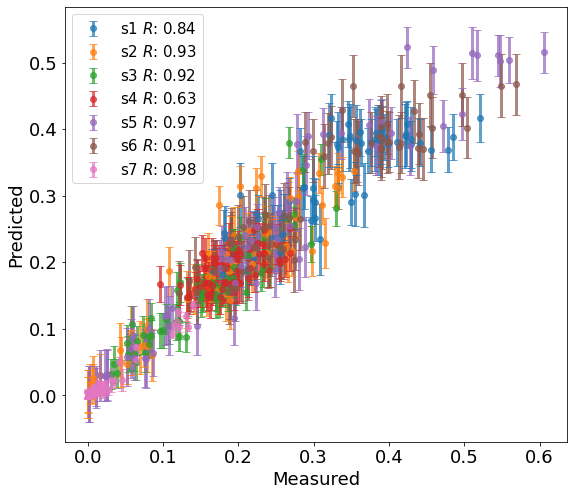

0.9224401457034199


In [11]:
plt.figure(figsize=(9,8))
r_vals = []
for i,s in enumerate(species):
    y_inds = np.in1d(kfold_species_names, s)
    y_s_true = np.array(kfold_y_true)[y_inds]
    y_s_pred = np.array(kfold_y_pred)[y_inds]
    y_s_stdv = np.array(kfold_y_stdv)[y_inds]
    
    # throw out zeros
    y_inds = y_s_true > 0.
    y_s_true = y_s_true[y_inds]
    y_s_pred = y_s_pred[y_inds]
    y_s_stdv = y_s_stdv[y_inds]
    
    r = linregress(y_s_true, y_s_pred).rvalue
    r_vals.append(r)
    plt.errorbar(y_s_true, y_s_pred, yerr = y_s_stdv, 
                 label=s+r" $R$: {:.2f}".format(r),
                 linewidth=3, capsize=4, c=f"C{i}", linestyle='none', marker='o', alpha=.7)

plt.legend(fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Measured", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.savefig("Results/glv_mf_all_kfold.pdf", dpi=150)
plt.show()
print(np.median(r_vals))